In [1]:
import os
import ember
import lightgbm as lgb
import numpy as np
import pandas as pd
import lief
import math
import matplotlib.pyplot as plt

binary_name = "mimikatz-backup.exe" #set this to the binary name, put the ones u want to test in /binaries

data_dir = "../ember2018/"

In [2]:
binary_location = f"/workspaces/torment-nexus/binaries/{binary_name}"

def get_feature_names() -> list[str]:
    byte_histogram = [f"Byte Histogram {a}" for a in range(256)] #256

    byte_entropy_histogram = [f"Byte Entropy Histogram {a}" for a in range(256)] #256

    strings_1 = [f"string.{a}" for a in ["numstrings", "avlength", "printables"]]
    strings_2 = [f"string.printabledist_{b}" for b in range(96)]
    strings_3 = [f"string.{a}" for a in ["entropy", "paths", "urls", "registry", "MZ"]] # 8 + 96
    strings = np.concatenate((strings_1,strings_2,strings_3))

    general_info = [f"general.{a}" for a in ["size", "vsize", "has_debug", "exports", "imports", "has_relocations", "has_resources", "has_signature", "has_tls", "symbols"]]

    header_coff = ["header.coff.timestamp"]
    header_coff_machine = [f"header.coff.machine_{a}" for a in range(10)]
    header_coff_characteristics = [f"header.coff.characteristic_{a}" for a in range(10)]
    header_coff_subsystem = [f"header.optional.subsystem_{a}" for a in range(10)]
    header_coff_dll_characteristics = [f"header.optional.dll_characteristic_{a}" for a in range(10)]
    header_coff_magic = [f"header.optional.magic_{a}" for a in range(10)]
    header_optional = [f"header.optional.{a}" for a in ["major_image_version", "minor_image_version", "major_linker_version", "minor_linker_version", "major_operating_system_version", "minor_operating_system_version", "major_subsystem_version", "minor_subsystem_version", "sizeof_code", "sizeof_headers", "sizeof_heap_commit"]] #12
    header = np.concatenate((header_coff,header_coff_machine,header_coff_characteristics,header_coff_subsystem,header_coff_dll_characteristics,header_coff_magic,header_optional))

    sections_general = [f"sections.{a}" for a in ["section_count", "num_empty_sections", "num_unnamed_sections", "num_read_execute_sections", "num_write_sections",]] #JUST general
    sections_section_sizes = [f"sections.section_{a}_size" for a in range(50)] # this messes with hashing which i will understand at a later time
    sections_section_entropy = [f"sections.section_{a}_entropy" for a in range(50)]
    sections_section_vsize = [f"sections.section_{a}_vsize" for a in range(50)]
    sections_entry_name = [f"sections.entry_name_{a}" for a in range(50)]
    sections_characteristics = [f"sections.characteristics_{a}" for a in range(50)]
    sections = np.concatenate((sections_general, sections_section_sizes, sections_section_entropy, sections_section_vsize, sections_entry_name, sections_characteristics))

    imports_libraries = [f"imports.libraries.library_{a}" for a in range(256)]
    imports_imports = [f"imports.import_{a}" for a in range(1024)]
    imports = np.concatenate((imports_libraries,imports_imports))

    exports = [f"exports.export_{a}" for a in range(128)]

    name_order = [a.lower() for a in ["EXPORT_TABLE", "IMPORT_TABLE", "RESOURCE_TABLE", "EXCEPTION_TABLE", "CERTIFICATE_TABLE","BASE_RELOCATION_TABLE", "DEBUG", "ARCHITECTURE", "GLOBAL_PTR", "TLS_TABLE", "LOAD_CONFIG_TABLE","BOUND_IMPORT", "IAT", "DELAY_IMPORT_DESCRIPTOR", "CLR_RUNTIME_HEADER"]]
    data_directories_unflat = [[f"directories.{a}_size", f"directories.{a}_vaddress"] for a in name_order]
    data_directories = [item for sublist in data_directories_unflat for item in sublist]


    feature_names = np.concatenate((byte_histogram, byte_entropy_histogram, strings, general_info, header, sections, imports, exports, data_directories))
    return feature_names

def classify_binary(binary_location:str) -> float:
    lgbm_model = lgb.Booster(model_file=os.path.join(data_dir, "ember_model_2018.txt"))
    extractor2 = ember.PEFeatureExtractor(2)

    file_data = open(binary_location, "rb").read()
    feature_vector = extractor2.feature_vector(file_data)

    return lgbm_model.predict([np.array(feature_vector, dtype=np.float32)])[0]

def classify_vectors(feature_vector:np.ndarray | pd.DataFrame) -> float:
    if type(feature_vector) is pd.DataFrame:
        feature_vector = feature_vector.to_numpy()

    lgbm_model = lgb.Booster(model_file=os.path.join(data_dir, "ember_model_2018.txt"))
    return lgbm_model.predict([np.array(feature_vector, dtype=np.float32)])[0]

def get_vectors(binary_location:str) -> np.ndarray:
    extractor2 = ember.PEFeatureExtractor(2)
    file_data = open(binary_location, "rb").read()
    return extractor2.feature_vector(file_data)

def get_dataframe(feature_vector:np.ndarray) -> pd.DataFrame:
    df = pd.DataFrame(feature_vector).T
    df.columns = get_feature_names()
    return df

In [3]:
get_dataframe(get_vectors(binary_location))

,Byte Histogram 0,Byte Histogram 1,Byte Histogram 2,Byte Histogram 3,Byte Histogram 4,Byte Histogram 5,Byte Histogram 6,Byte Histogram 7,Byte Histogram 8,Byte Histogram 9,...,directories.load_config_table_size,directories.load_config_table_vaddress,directories.bound_import_size,directories.bound_import_vaddress,directories.iat_size,directories.iat_vaddress,directories.delay_import_descriptor_size,directories.delay_import_descriptor_vaddress,directories.clr_runtime_header_size,directories.clr_runtime_header_vaddress
0,0.208882,0.008701,0.004243,0.00469,0.008037,0.002896,0.002781,0.002621,0.010049,0.001845,...,0.0,0.0,0.0,0.0,2416.0,610304.0,96.0,912092.0,0.0,0.0


In [4]:
def objective_function(df):
    if type(df) is pd.DataFrame:
        df = df.to_numpy()
        
    lgbm_model = lgb.Booster(model_file=os.path.join(data_dir, "ember_model_2018.txt"))
    return lgbm_model.predict([np.array(df, dtype=np.float32)])[0]

def get_dataframe(feature_vector:np.ndarray) -> pd.DataFrame:
    df = pd.DataFrame(feature_vector).T
    df.columns = get_feature_names()
    return df

def get_vectors(binary_location:str) -> np.ndarray:
    extractor2 = ember.PEFeatureExtractor(2)
    file_data = open(binary_location, "rb").read()
    return extractor2.feature_vector(file_data)

    

In [5]:


df = get_dataframe(get_vectors(binary_location))



num_particles = 50
num_iterations = 7
dim = df.shape[1]
c1 = 1.2
c2 = 1.2
w = .8 #inertia
boundsdict = {"header.coff.timestamp": (0, 0xFFFFFFFF),
            "directories.certificate_table_size": (0,0xFFFFFFFF),
            "directories.debug_vaddress":(0,0xFFFFFFFF),
            "directories.certificate_table_vaddress": (0,0xFFFFFFFF),
            "header.optional.major_subsystem_version":(7,10),
            "directories.export_table_vaddress":(0,0xFFFFFFFF),
            "directories.export_table_size":(0,0xFFFFFFFF)
            }





changeable_str = ["header.coff.timestamp",
                "directories.certificate_table_size",
                "directories.debug_vaddress",
                "directories.certificate_table_vaddress",
                "directories.export_table_vaddress",
                "directories.export_table_size",
                "header.optional.major_subsystem_version"]
bounds = []
changeable = []
for index,feature in enumerate(df):
    if feature not in changeable_str:
        bounds.append((df[feature].iloc[0], df[feature].iloc[0]))
    else:
        bounds.append(boundsdict[feature])
        changeable.append(index)

particles = np.random.uniform([b[0] for b in bounds], [b[1] for b in bounds], (num_particles, dim))
velocities = np.random.uniform(-1, 1, (num_particles, dim))
personal_best_positions = np.copy(particles)
personal_best_scores = np.array([objective_function(p) for p in particles])
global_best_position = personal_best_positions[np.argmin(personal_best_scores)]

particle_df = pd.DataFrame(particles, columns=get_feature_names())
particle_df["Particle"] = range(num_particles)

for iteration in range(num_iterations):
    for i in range(num_particles):
        for j in changeable:
            velocities[i, j] = (w * velocities[i, j] +
                                c1 * np.random.rand() * (personal_best_positions[i, j] - particles[i, j]) +
                                c2 * np.random.rand() * (global_best_position[j] - particles[i, j]))
            particles[i, j] += velocities[i, j]
            particles[i, j] = np.clip(particles[i, j], bounds[j][0], bounds[j][1])
        score = objective_function(particles[i])
        if score < personal_best_scores[i]:
            personal_best_scores[i] = score
            personal_best_positions[i] = particles[i]
        # print(f"This score: {score}, best score: {min(personal_best_scores)}")
        row = list(particles[i]) +  [i]
        particle_df.loc[len(particle_df)] = row
    global_best_position = personal_best_positions[np.argmin(personal_best_scores)]
    print(f"Best so far: {min(personal_best_scores)}, particle #{np.argmin(personal_best_scores)}")

print("Best position:", global_best_position)

bestpositiondf = get_dataframe(global_best_position)
binary = lief.PE.parse(binary_location)
data_directory = binary.data_directories 

timestamp = bestpositiondf["header.coff.timestamp"]
certificate_table_vaddress = bestpositiondf["directories.certificate_table_vaddress"]
certificate_table_size = bestpositiondf["directories.certificate_table_size"]
debug_vaddress = bestpositiondf["directories.debug_vaddress"]
export_table_vaddress = bestpositiondf["directories.export_table_vaddress"]
export_table_size = bestpositiondf["directories.export_table_size"]
major_subsystem_version = math.ceil(bestpositiondf["header.optional.major_subsystem_version"])
binary.header.time_date_stamps = timestamp
data_directory[4].rva = certificate_table_vaddress
data_directory[4].size = certificate_table_size
data_directory[6].rva = debug_vaddress
data_directory[0].rva = export_table_vaddress
data_directory[0].size = export_table_size
binary.optional_header.major_subsystem_version = major_subsystem_version

binary.write(f"/workspaces/torment-nexus/binaries/output/edited.exe")

Best so far: 0.0010469075342053825, particle #20
Best so far: 0.0010469075342053825, particle #20
Best so far: 0.0009568506267939963, particle #49
Best so far: 0.0009568506267939963, particle #9
Best so far: 0.0009442102815003541, particle #29
Best so far: 0.0009442102815003541, particle #29
Best so far: 0.0009442102815003541, particle #29
Best position: [2.08881691e-01 8.70080758e-03 4.24287515e-03 ... 9.12092000e+05
 0.00000000e+00 0.00000000e+00]


Can't write in /workspaces/torment-nexus/binaries/output/edited.exe


In [6]:
display_df = pd.DataFrame()
display_df["Particle"] = particle_df["Particle"]
display_df["X"] = particle_df.iloc[:,changeable].iloc[:,[2]]
display_df["Y"] = particle_df.iloc[:,changeable].iloc[:,[3]]

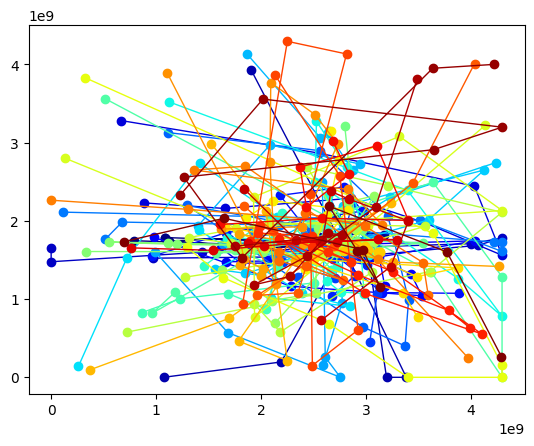

In [7]:
unique_particles = display_df['Particle'].unique()
colors = plt.cm.jet(np.linspace(0, 1, len(unique_particles)))

# Plot each particle's movement
for particle, color in zip(unique_particles, colors):
    particle_data = display_df[display_df['Particle'] == particle]
    plt.plot(particle_data['X'], particle_data['Y'], marker='o', linestyle='-', color=color, label=f'Particle {particle}', linewidth=1)

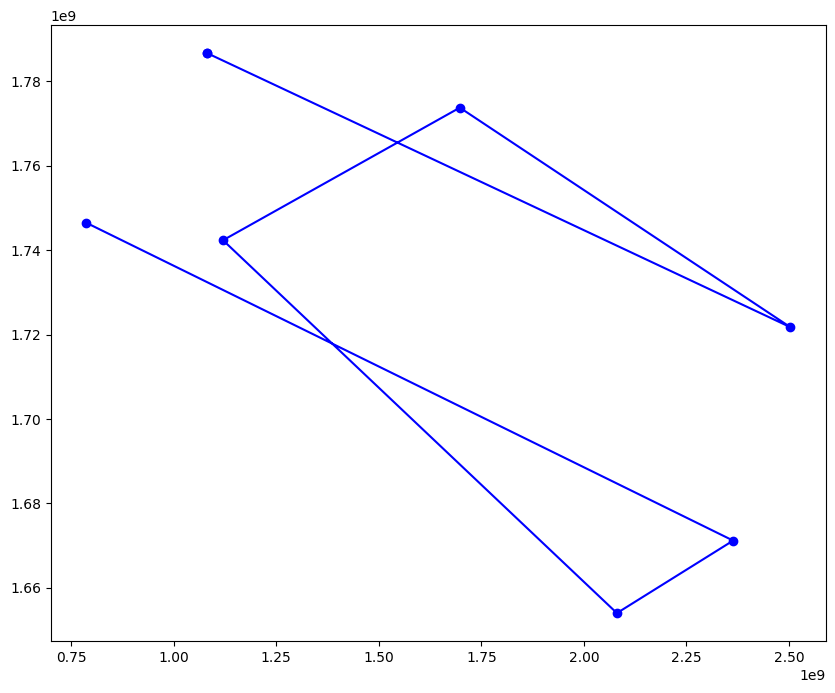

In [8]:

plt.figure(figsize=(10, 8))

unique_particles = display_df['Particle'].unique()
colors = plt.cm.jet(np.linspace(0, 1, len(unique_particles)))

particle_number = 0

# Isolate the specific particle's data
particle_data = display_df[display_df['Particle'] == particle_number]

# Plot the isolated particle's movement
plt.plot(particle_data['X'], particle_data['Y'], marker='o', linestyle='-', color='blue', label=f'Particle {particle_number}')